In [1]:
import re
import os
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor

PROJECT_DIR = Path(os.getcwd())
sys.path.append(str(Path(PROJECT_DIR, 'utils')))

# Загрузка данных

In [2]:
X_train = pd.read_csv(str(Path(PROJECT_DIR, 'ds_problem', 'problem_train.csv')), low_memory=False)
labels = pd.read_csv(str(Path(PROJECT_DIR, 'ds_problem', 'problem_labels.csv')))
X_test = pd.read_csv(str(Path(PROJECT_DIR, 'ds_problem', 'problem_test.csv')), low_memory=False)

In [3]:
X_train.head(10)

id release  n_0000  n_0001    n_0002  n_0003  n_0004    n_0005  n_0006  \
0  11193       a     NaN     NaN  0.025449     NaN     NaN  0.368421     NaN   
1  11382       a     NaN     NaN  0.031297     NaN     NaN  0.315789     NaN   
2  16531       a     NaN     NaN  0.024475     NaN     NaN  0.342105     NaN   
3   1896       a     NaN     NaN  0.041694     NaN     NaN  0.447368     NaN   
4  18262       c     NaN     NaN  0.038120     NaN     NaN  0.315789     NaN   
5  10540       b     NaN     NaN  0.039420     NaN     NaN  0.368421     NaN   
6   5244       c     NaN     NaN  0.050141     NaN     NaN  0.394737     0.2   
7   1929       a     NaN     NaN  0.049166     NaN     NaN  0.710526     NaN   
8  11928       b     NaN     NaN  0.050249     NaN     NaN  0.394737     NaN   
9   6327       a     NaN     NaN  0.049491     NaN     NaN  0.500000     NaN   

   n_0007  ...  c_1368  c_1369  c_1370  c_1371  c_1372  c_1373  c_1374  \
0     NaN  ...     NaN     NaN     NaN     NaN       a     NaN       q   
1     NaN  ...     NaN     NaN       a     NaN       a     NaN     NaN   
2     NaN  ...     NaN     NaN       a     NaN       a     NaN       b   
3     NaN  ...     NaN     NaN     NaN     NaN       a     NaN     NaN   
4     NaN  ...     NaN     NaN       b     NaN       a     NaN       a   
5     NaN  ...     NaN     NaN     NaN     NaN       a     NaN     NaN   
6     NaN  ...     NaN     NaN     NaN     NaN       a     NaN     NaN   
7     NaN  ...     NaN     NaN     NaN     NaN       a     NaN     NaN   
8     NaN  ...     NaN     NaN     NaN     NaN       b     NaN     NaN   
9     NaN  ...     NaN     NaN     NaN     NaN       a     NaN     NaN   

   c_1375  c_1376  c_1377  
0     NaN     NaN     NaN  
1     NaN     NaN     NaN  
2     NaN     NaN     NaN  
3     NaN     NaN     NaN  
4     NaN     NaN     NaN  
5     NaN     NaN     NaN  
6     NaN     NaN     NaN  
7     NaN     NaN     NaN  
8     NaN     NaN       b  
9     NaN     NaN     NaN  

[10 rows x 1379 columns]

In [4]:
print(f'Размер X_train: {X_train.shape}', f'Размер labels: {labels.shape}', f'Размер X_test: {X_test.shape}', sep='\n')

Размер X_train: (8000, 1379)
Размер labels: (8000, 15)
Размер X_test: (2000, 1379)


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 1379 entries, id to c_1377
dtypes: float64(345), int64(9), object(1025)
memory usage: 84.2+ MB


Предварительно можно сказать, что в датасете 345 числовых признаков, 9 либо числовых либо категориальных (в зависимости от количества уникальных значений) и 1025 категориальных признаков.

# EDA

# Заполненность признаков

In [6]:
isna_df = pd.DataFrame({
    'feature': X_train.columns,
    'count_nan': X_train.isna().sum()
}).reset_index(drop=True)

isna_df['percent_of_nan'] = isna_df['count_nan']/X_train.shape[0]
isna_df = isna_df.sort_values(by='count_nan', ascending=False)
isna_df

feature  count_nan  percent_of_nan
960   c_0959       8000             1.0
259   o_0257       8000             1.0
804   c_0803       8000             1.0
1149  c_1148       8000             1.0
785   c_0784       8000             1.0
...      ...        ...             ...
1146  c_1145          0             0.0
111   n_0109          0             0.0
110   n_0108          0             0.0
1349  c_1348          0             0.0
0         id          0             0.0

[1379 rows x 3 columns]

In [7]:
arr_proc = [1, 0.99, 0.85, 0.8, 0.5, 0.2]
for proc in arr_proc:
    num_nan = isna_df[isna_df['percent_of_nan'] >= proc].shape[0]
    print(f'Количество признаков с заполненностью не nan {100 - proc * 100} %: {num_nan}')

Количество признаков с заполненностью не nan 0 %: 30
Количество признаков с заполненностью не nan 1.0 %: 575
Количество признаков с заполненностью не nan 15.0 %: 998
Количество признаков с заполненностью не nan 20.0 %: 1044
Количество признаков с заполненностью не nan 50.0 %: 1159
Количество признаков с заполненностью не nan 80.0 %: 1281


Видим, что уже как минимум 30 признаков можно просто выкинуть из датасета, так как они не несут никакой информации. В целом датасет плохо заполнен. Предстоит работа с обработкой nan и фильтрации важных признаков.

In [8]:
for column in X_train.columns:
    if X_train[column].dtype == 'int64':
        print(f'Уникальные значения в признаке {column} == {len(X_train[column].unique())}')

Уникальные значения в признаке id == 8000
Уникальные значения в признаке n_0047 == 1
Уникальные значения в признаке n_0050 == 1
Уникальные значения в признаке n_0052 == 1
Уникальные значения в признаке n_0061 == 1
Уникальные значения в признаке n_0075 == 1
Уникальные значения в признаке n_0091 == 1
Уникальные значения в признаке o_0176 == 363
Уникальные значения в признаке o_0264 == 11


Видим, что признаки n_0047, n_0050, n_0052, n_0061, n_0075, n_0091 имеют одно уникальное значение. Вместе с nan их можно рассматривать как бинарные признаки (дальше окажется, что в них нет nan). Признак o_0264 будем рассматривать как категориальный, а признак o_0176 как числовой дабы избежать сильного увелечения пространства признаков при onehot encoding.

In [9]:
NUM_FEATURES_INT = ['o_0176']
CAT_FEATURES_OBJECT = [column for column in X_train.columns if X_train[column].dtype == 'object']
CAT_FEATURES_OBJECT.append('o_0264')
NUM_FEATURES_FLOAT = [column for column in X_train.columns if X_train[column].dtype == 'float64']
CAT_FEATURES_BIN = ['n_0047', 'n_0050', 'n_0052', 'n_0061', 'n_0075', 'n_0091']

In [10]:
for col in CAT_FEATURES_BIN:
    print(X_train[col].value_counts())

n_0047
1    8000
Name: count, dtype: int64
n_0050
1    8000
Name: count, dtype: int64
n_0052
1    8000
Name: count, dtype: int64
n_0061
1    8000
Name: count, dtype: int64
n_0075
1    8000
Name: count, dtype: int64
n_0091
1    8000
Name: count, dtype: int64


То есть эти признаки с одним уникальным значением не несут никакой информации. Их можно выкинуть.

In [11]:
X_train['o_0176'].value_counts()

o_0176
369    825
329    161
149    124
352    117
239     85
      ... 
198      1
138      1
356      1
168      1
304      1
Name: count, Length: 363, dtype: int64

In [12]:
isna_df[isna_df['feature'] == 'o_0176']

feature  count_nan  percent_of_nan
178  o_0176          0             0.0

In [14]:
for col in labels.columns.drop(['id']):
    print(col, sum(labels[col]))

service_a 3777
service_b 2626
service_c 2093
service_d 136
service_e 431
service_f 233
service_g 415
service_h 2376
service_i 129
service_j 6786
service_k 6256
service_l 864
service_m 709
service_n 1424


In [15]:
isna_df.columns

Index(['feature', 'count_nan', 'percent_of_nan'], dtype='object')

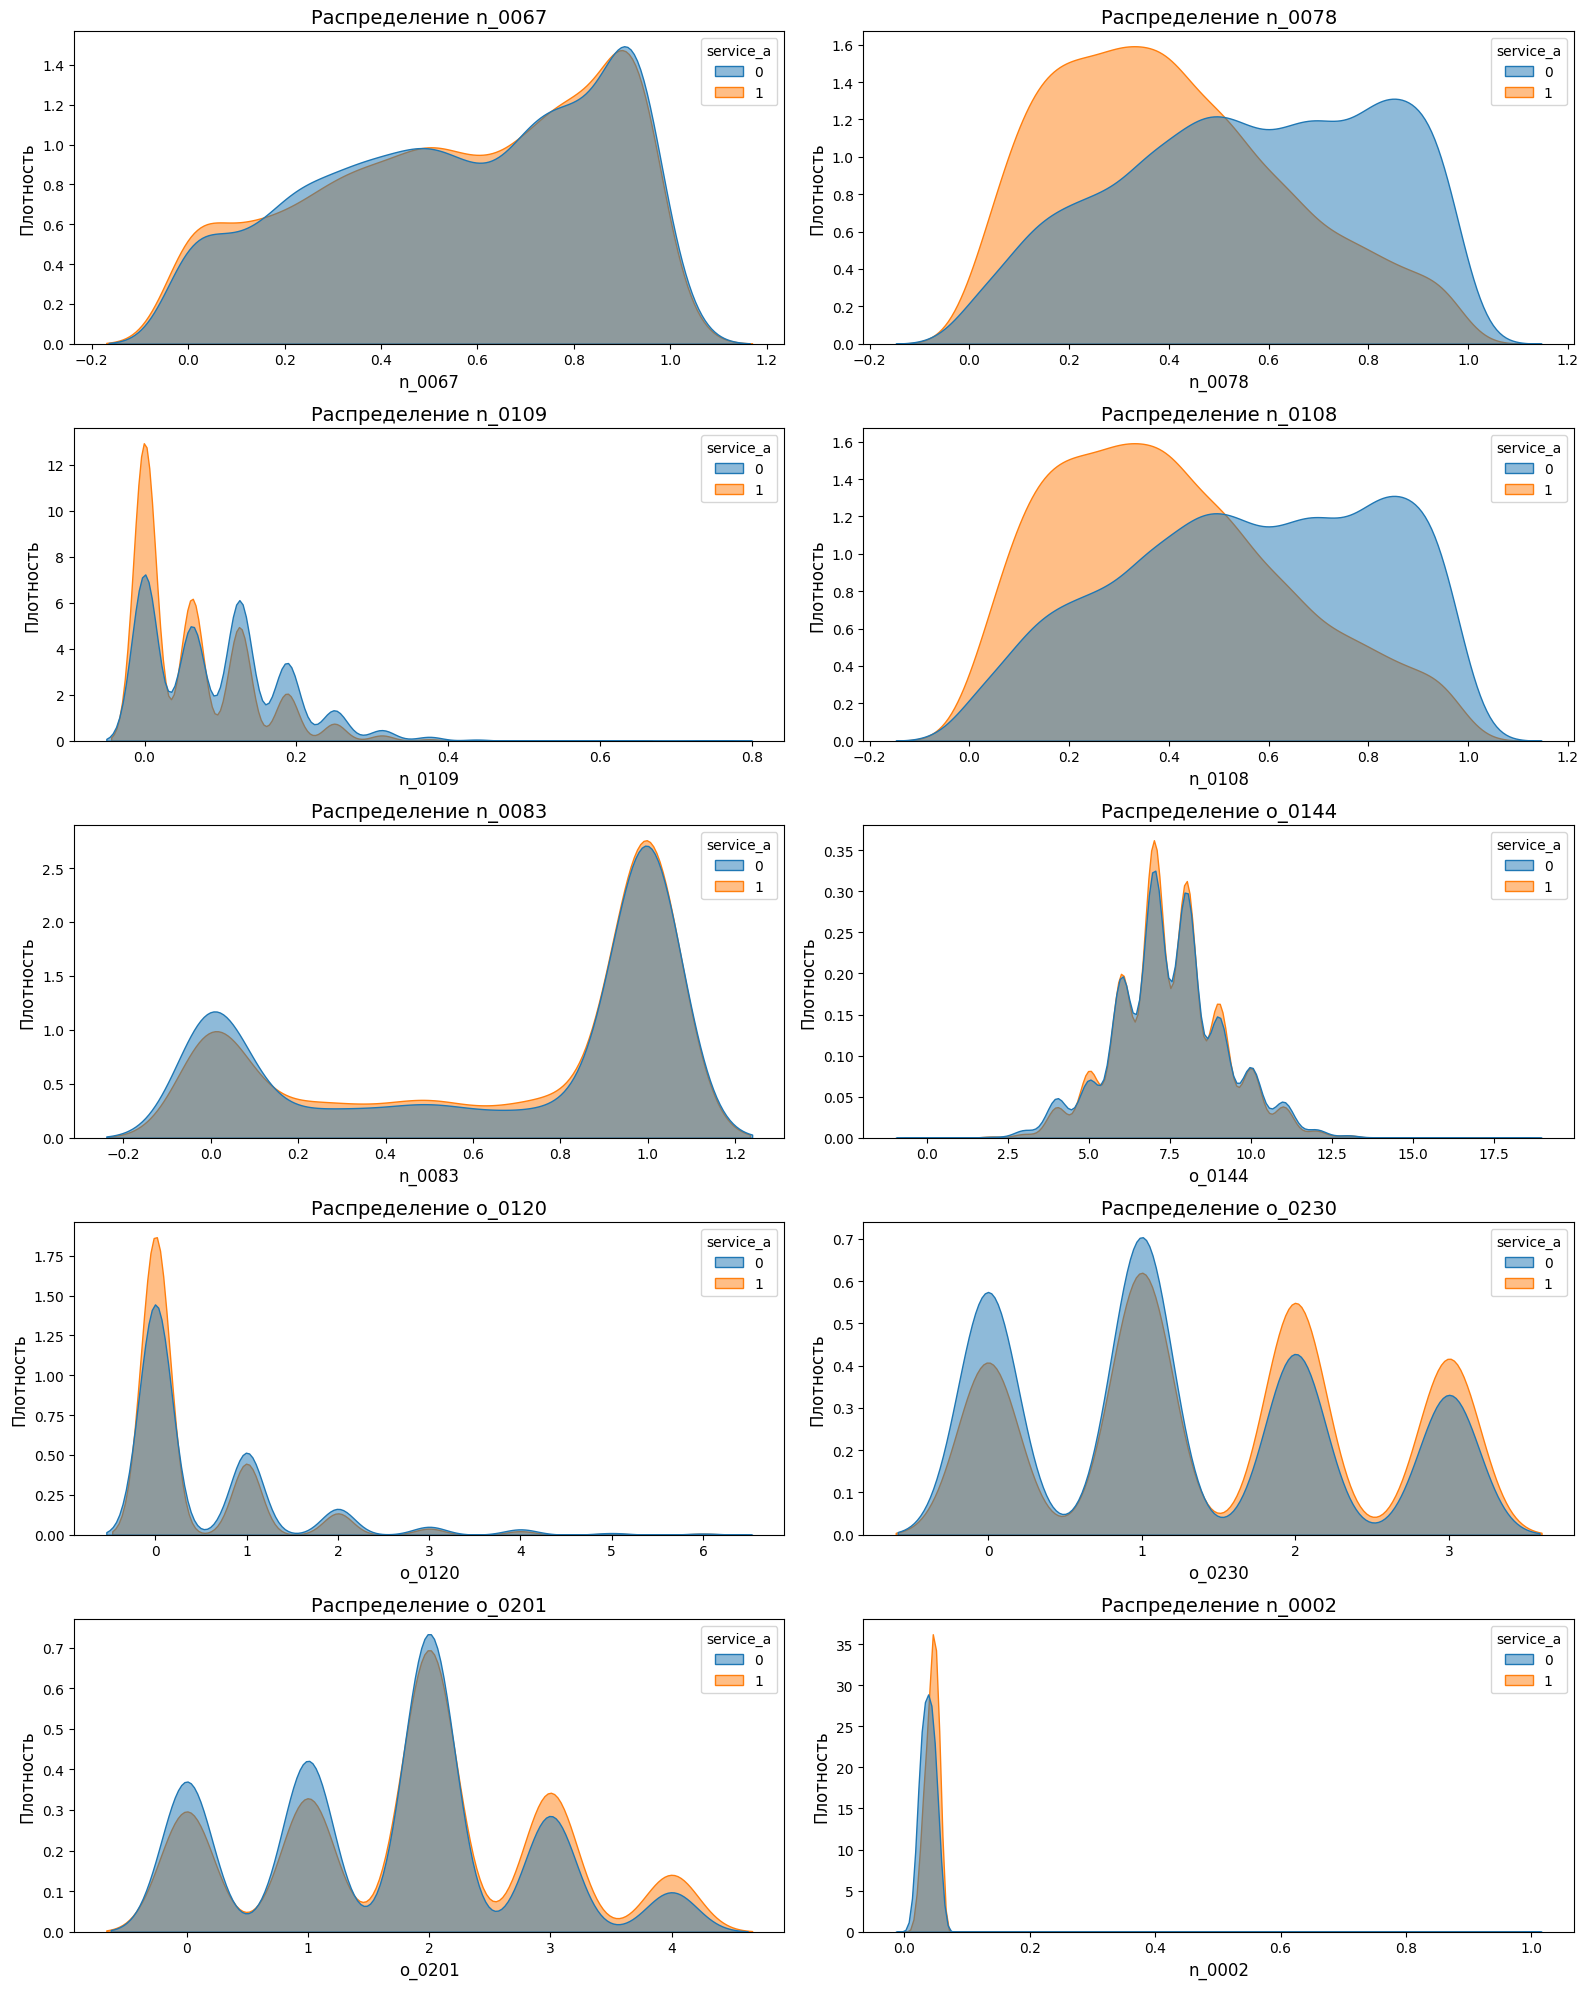

In [16]:
data = pd.concat([X_train, labels], axis=1)

numeric_features = X_train.select_dtypes(include=['float64']).columns  # Список всех float64-признаков

isna_numeric_df = isna_df[isna_df['feature'].isin(numeric_features)]

top_filled_features = isna_numeric_df.nsmallest(10, 'percent_of_nan')['feature']

n_cols = 2  # Количество графиков в одном ряду
n_rows = (len(top_filled_features) + n_cols - 1) // n_cols  # Количество строк
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

# Построение графиков для каждого признака
for i, feature in enumerate(top_filled_features):
    sns.kdeplot(
        data=data,  # Замените df на ваше имя DataFrame
        x=feature,
        hue='service_a',  # Замените 'target' на имя вашего целевого признака
        fill=True,
        common_norm=False,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f'Распределение {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Плотность', fontsize=12)

# Удаление пустых графиков, если число признаков меньше, чем количество подграфиков
for j in range(len(top_filled_features), len(axes)):
    fig.delaxes(axes[j])

# Финальные настройки
plt.tight_layout()
plt.show()


Посмотрим теперь в сравнении для разных таргетов какие распределения.

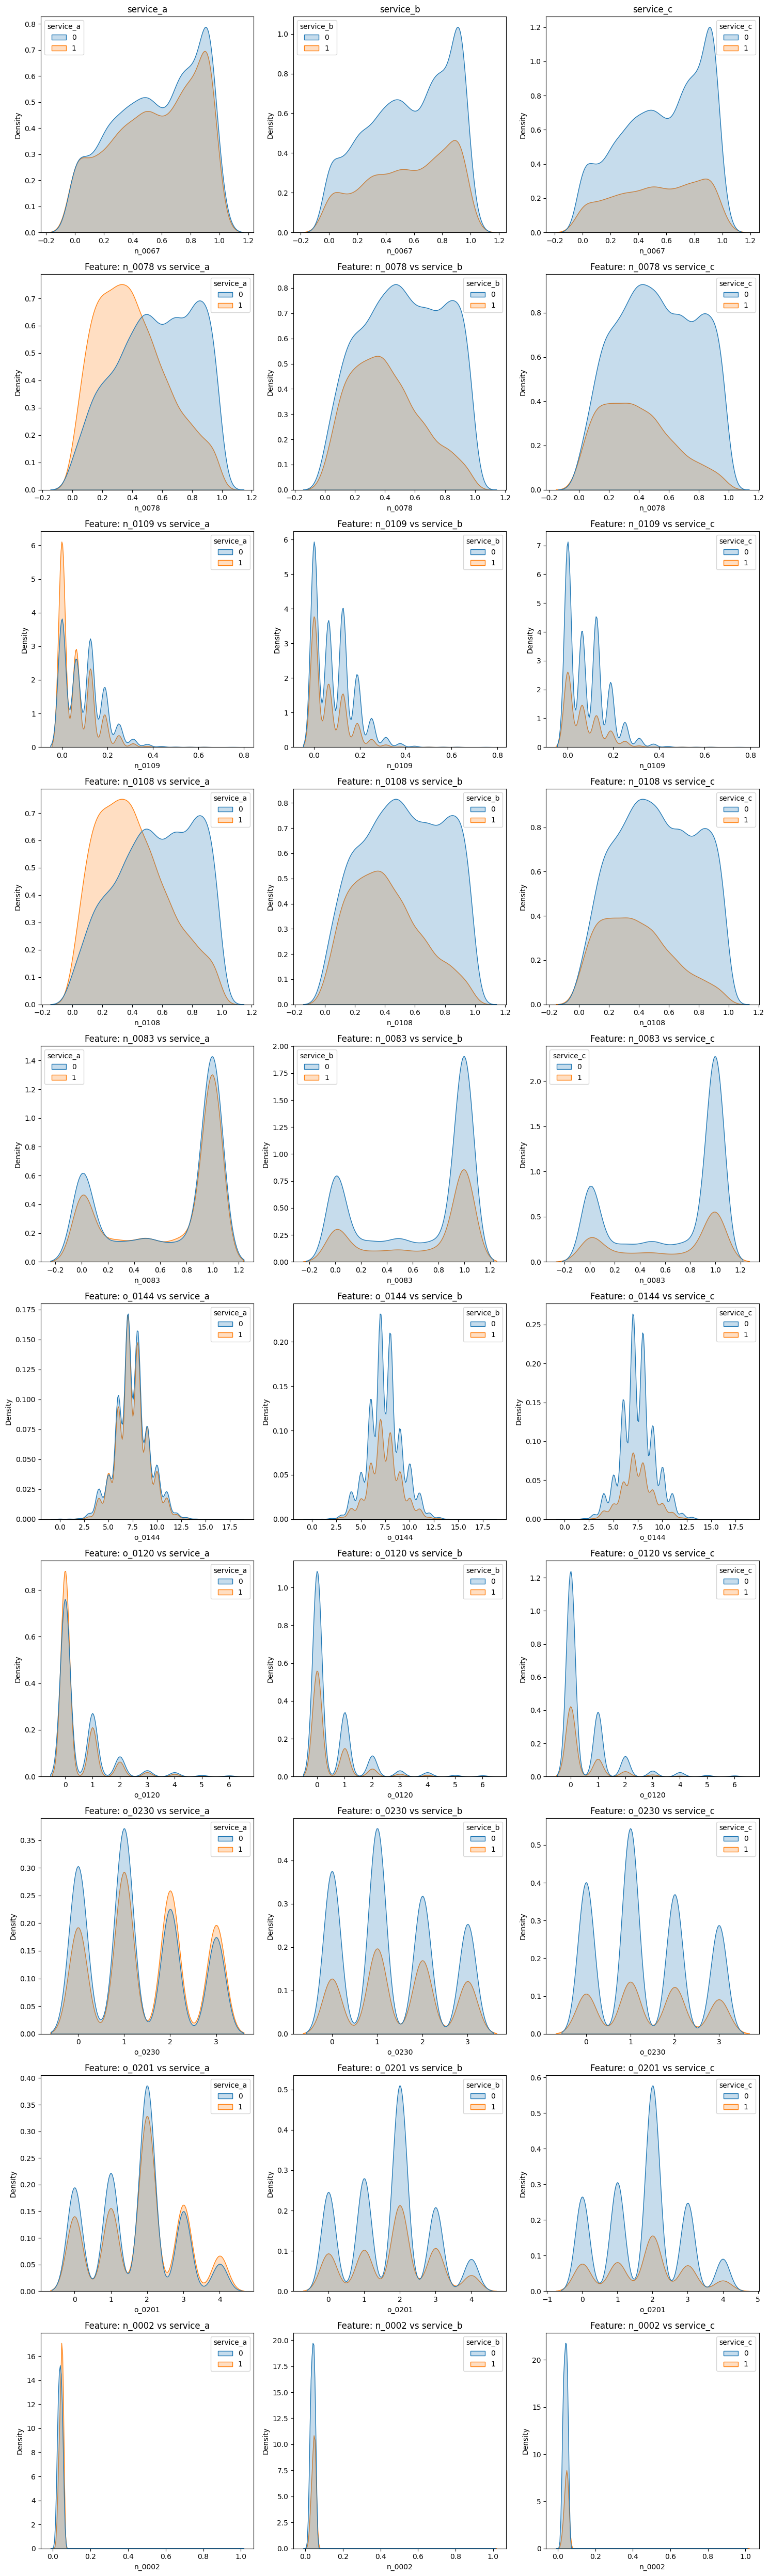

In [17]:

fig, axes = plt.subplots(len(top_filled_features), 3, figsize=(15, 5 * len(top_filled_features)))
for i, feature in enumerate(top_filled_features):
    for j, target in enumerate(labels.iloc[:, 1:4].columns):
        ax = axes[i, j]
        sns.kdeplot(data=data, x=feature, hue=data[target], fill=True, ax=ax)
        ax.set_title(f"Feature: {feature} vs {target}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Density")
        if i == 0:  # Добавим заголовок для каждого столбца
            ax.set_title(target)

plt.tight_layout()
plt.show()

Очень схожие распределения, но можно заметить, что у всех признаков идет уменьшение плотности для класса 1.

Посмотрим для следующих 3 таргетов:

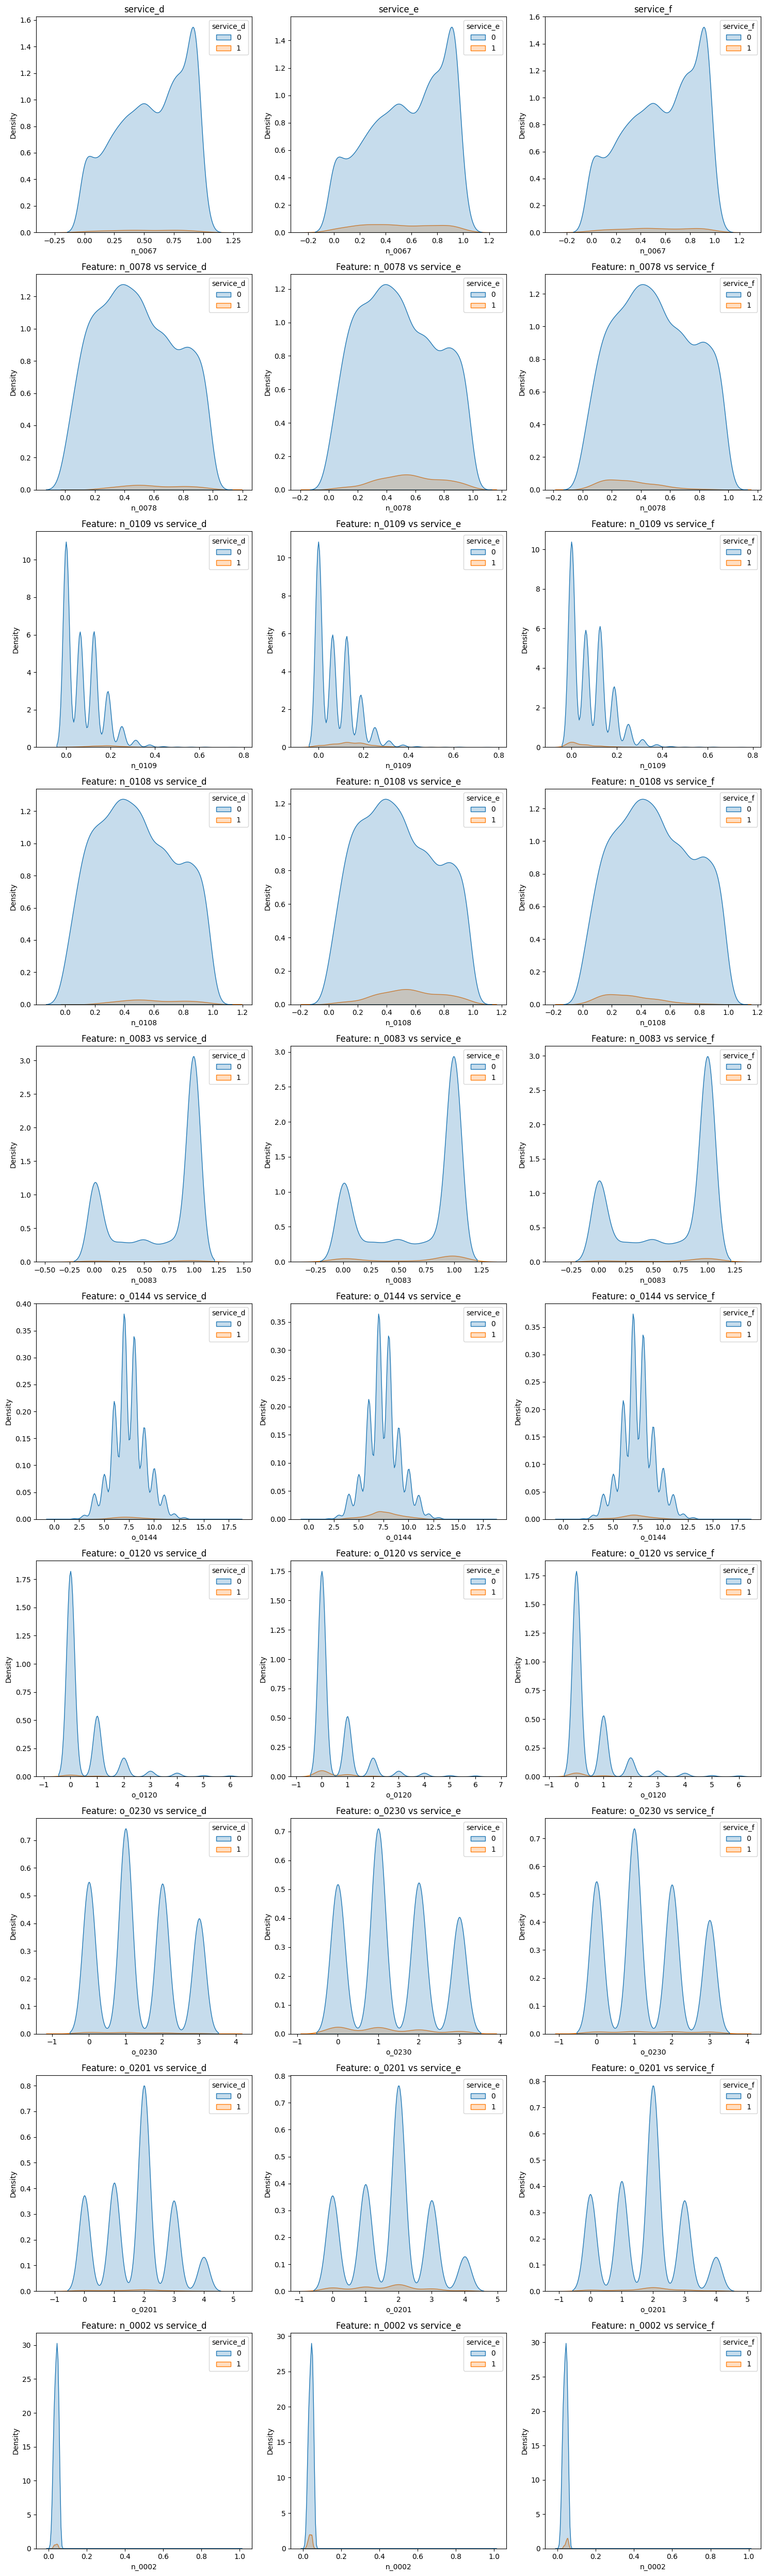

In [9]:
fig, axes = plt.subplots(len(top_filled_features), 3, figsize=(15, 5 * len(top_filled_features)))
for i, feature in enumerate(top_filled_features):
    for j, target in enumerate(labels.iloc[:, 4:7].columns):
        ax = axes[i, j]
        sns.kdeplot(data=data, x=feature, hue=data[target], fill=True, ax=ax)
        ax.set_title(f"Feature: {feature} vs {target}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Density")
        if i == 0:  # Добавим заголовок для каждого столбца
            ax.set_title(target)

plt.tight_layout()
plt.show()

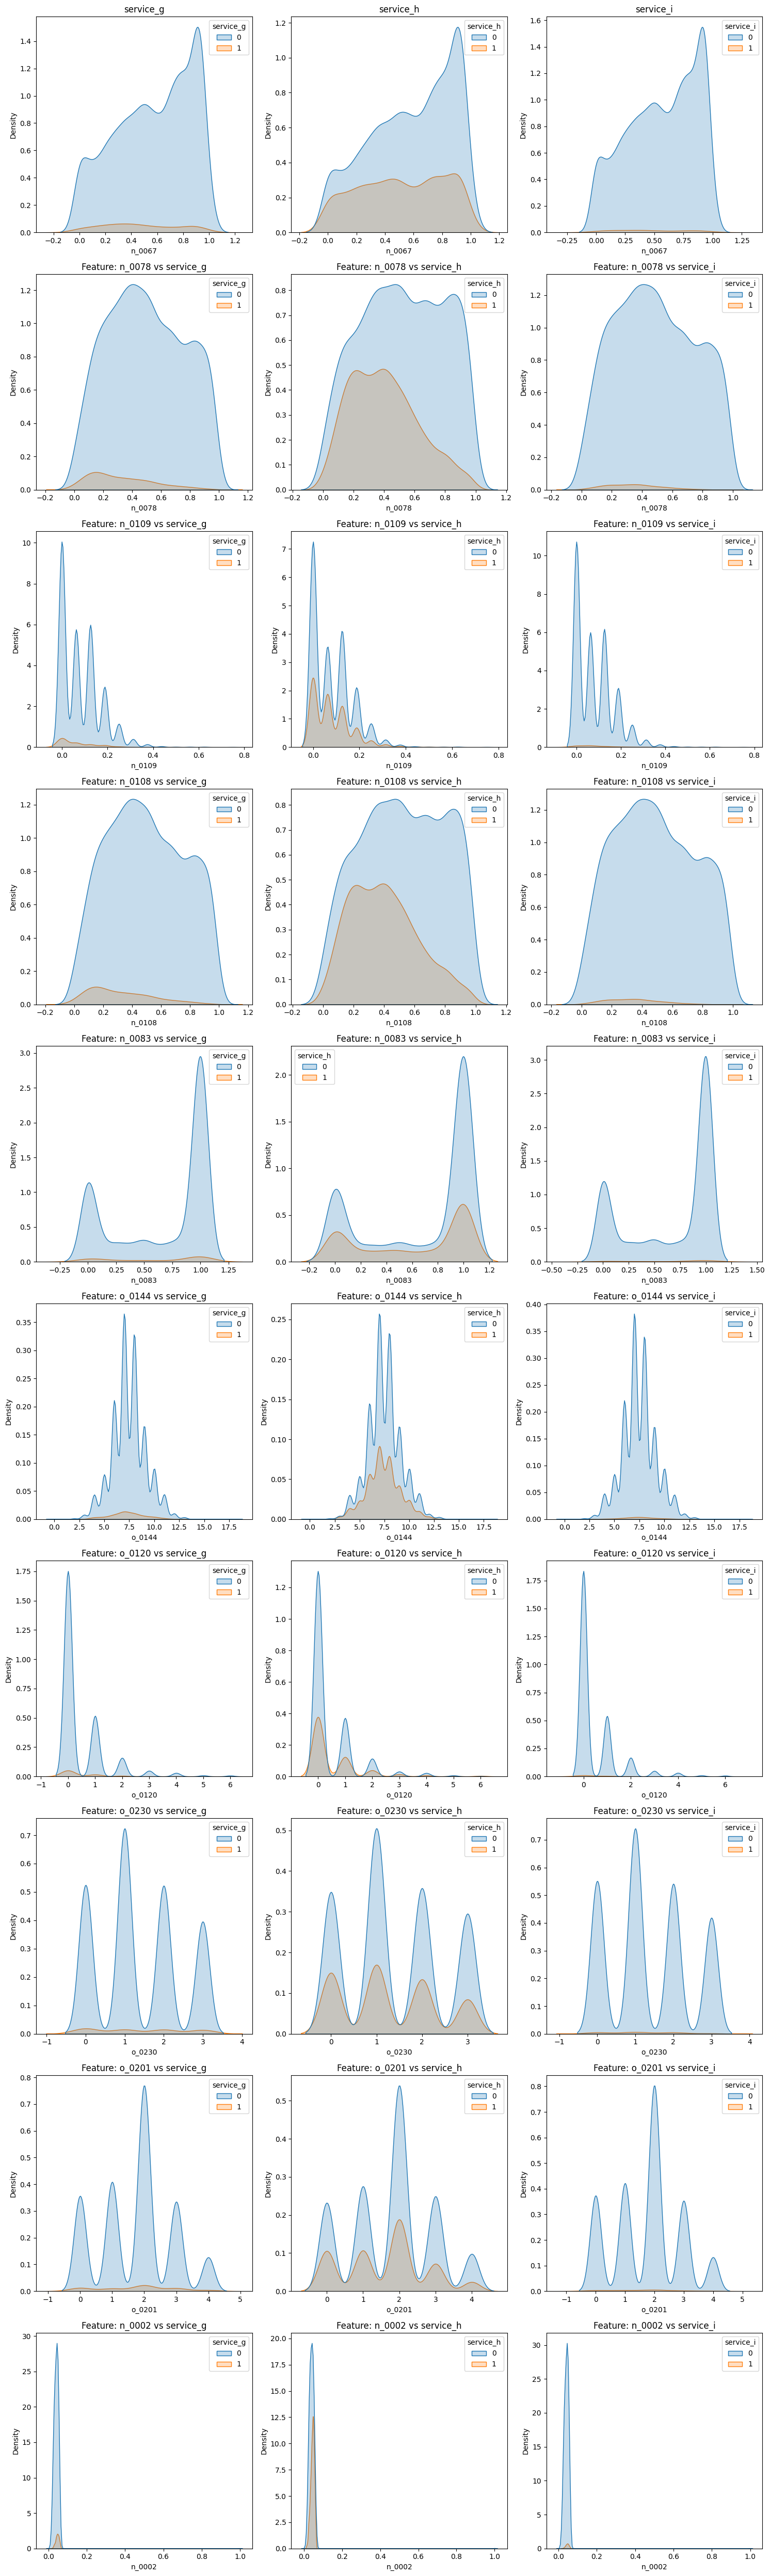

In [10]:
fig, axes = plt.subplots(len(top_filled_features), 3, figsize=(15, 5 * len(top_filled_features)))
for i, feature in enumerate(top_filled_features):
    for j, target in enumerate(labels.iloc[:, 7:10].columns):
        ax = axes[i, j]
        sns.kdeplot(data=data, x=feature, hue=data[target], fill=True, ax=ax)
        ax.set_title(f"Feature: {feature} vs {target}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Density")
        if i == 0:  # Добавим заголовок для каждого столбца
            ax.set_title(target)

plt.tight_layout()
plt.show()

В общем, можно сказать, что различие в распределении идет в основном только со вторым классом. Первый практически не меняется

Посмотрим теперь на самые заполненные категориальные признаки

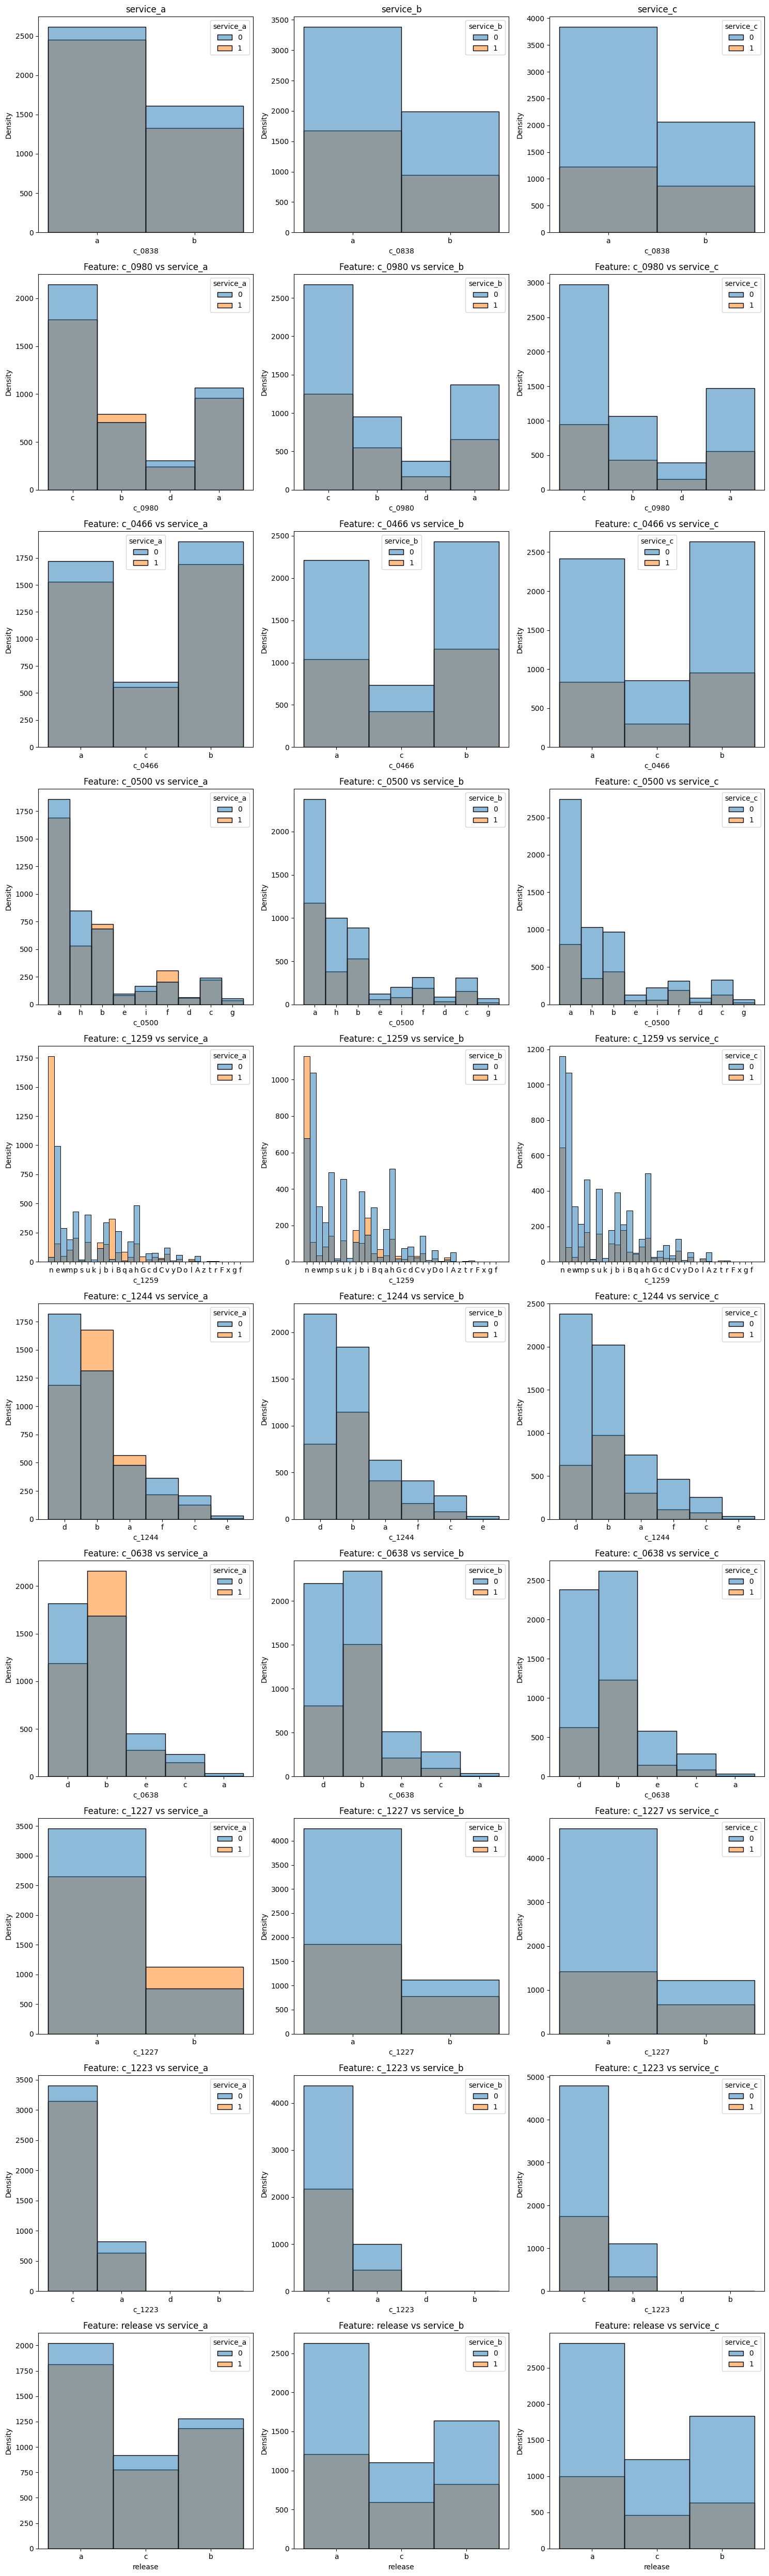

In [17]:
cat_features = X_train.select_dtypes(include=['object']).columns 

isna_cat_df = isna_df[isna_df['feature'].isin(cat_features)]

top_filled_features = isna_cat_df.nsmallest(10, 'percent_of_nan')['feature']

fig, axes = plt.subplots(len(top_filled_features), 3, figsize=(15, 5 * len(top_filled_features)))
for i, feature in enumerate(top_filled_features):
    for j, target in enumerate(labels.iloc[:, 1:4].columns):
        ax = axes[i, j]
        sns.histplot(data=data, x=feature, hue=data[target], fill=True, ax=ax)
        ax.set_title(f"Feature: {feature} vs {target}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Density")
        if i == 0:  # Добавим заголовок для каждого столбца
            ax.set_title(target)

plt.tight_layout()
plt.show()

# Посмотрим теперь на числовые признаки как на временные ряды

In [18]:
num_filtered_features = isna_numeric_df[isna_numeric_df['percent_of_nan'] <= 0.5]['feature'].to_list()
sample = data[num_filtered_features].sample(10)


In [67]:
sample

o_0315  o_0125  n_0100  o_0217  o_0223  o_0241    n_0034    n_0099  \
6413     NaN     NaN     NaN     4.0    36.0     NaN       NaN  0.395349   
56       NaN     3.0     NaN     4.0    24.0    21.0       NaN  0.395349   
1038     0.0     6.0    0.00     4.0     9.0    20.0  0.104478  0.418605   
4257     NaN     NaN    0.08     NaN     NaN     NaN  0.164179       NaN   
2780     NaN     NaN     NaN     NaN     NaN     NaN       NaN  0.372093   
4477     NaN     NaN     NaN     NaN     NaN     NaN       NaN       NaN   
4228     NaN    10.0     NaN     5.0    23.0    20.0       NaN       NaN   
3777     NaN     NaN    0.08     NaN     NaN     NaN  0.179104       NaN   
2951     0.0    11.0    0.04     5.0     9.0    21.0  0.268657  0.441860   
7412     NaN     NaN    0.02     NaN     NaN     NaN  0.149254       NaN   

      o_0270  o_0175  ...    n_0002  o_0201  o_0230  o_0144  o_0120    n_0083  \
6413     NaN     NaN  ...       NaN     4.0     2.0     6.0     0.0  0.000000   
56       NaN    11.0  ...  0.044293     2.0     1.0    10.0     0.0  1.000000   
1038     6.0     NaN  ...  0.028698     1.0     1.0     8.0     3.0  0.000000   
4257     NaN     NaN  ...  0.020035     1.0     1.0     7.0     0.0  1.000000   
2780     NaN     8.0  ...  0.047325     2.0     2.0     6.0     0.0  1.000000   
4477     NaN     9.0  ...  0.047109     1.0     3.0     7.0     1.0  0.000000   
4228     7.0     9.0  ...  0.037903     2.0     1.0     7.0     0.0  0.000000   
3777     NaN     NaN  ...  0.032597     2.0     1.0     7.0     0.0  1.000000   
2951     5.0     NaN  ...  0.032489     2.0     2.0     7.0     0.0  0.833333   
7412     NaN    10.0  ...  0.039095     0.0     2.0     8.0     0.0  0.833333   

        n_0067    n_0078  n_0109    n_0108  
6413  1.000000  0.166667  0.0000  0.166667  
56    0.571429  0.400000  0.0625  0.400000  
1038  0.071429  0.900000  0.0000  0.900000  
4257  0.785714  0.933333  0.1250  0.933333  
2780  0.285714  0.100000  0.0000  0.100000  
4477  0.714286  0.133333  0.0000  0.133333  
4228  0.285714  0.500000  0.0625  0.500000  
3777  0.571429  0.733333  0.0000  0.733333  
2951  0.928571  0.933333  0.2500  0.933333  
7412  0.071429  0.366667  0.0625  0.366667  

[10 rows x 32 columns]

Чисто визуально можно заметить, что фичи, имеющие шаблон n_{}, содержат числа от 0 до 1

Фичи, имеющие шаблон o_{}, на самом деле являются int.

Посмотрим на фичи n_{} как на временнные ряды относительно класса 0 и 1

In [61]:
set([col[0] for col in num_filtered_features])

{'n', 'o'}

In [12]:
features_n = [col for col in num_filtered_features if col[0] == 'n']
features_o = [col for col in num_filtered_features if col[0] == 'o']

In [69]:
maxx_n = 0
maxx_o = 0
minn_n = float('inf')
minn_o = float('inf')

for col in num_filtered_features:
    if col[0] == 'n':
        maxx_n = max(maxx_n, X_train[col].max())
        minn_n = min(minn_n, X_train[col].min())
    if col[0] == 'o':
        maxx_o = max(maxx_o, X_train[col].max())
        minn_o = min(minn_o, X_train[col].min())
print(f'Min and max of n_features = ({minn_n}, {maxx_n}), Min and max of o_features = ({minn_o}, {maxx_o})')

Min and max of n_features = (0.0, 1.0), Min and max of o_features = (0.0, 45.0)


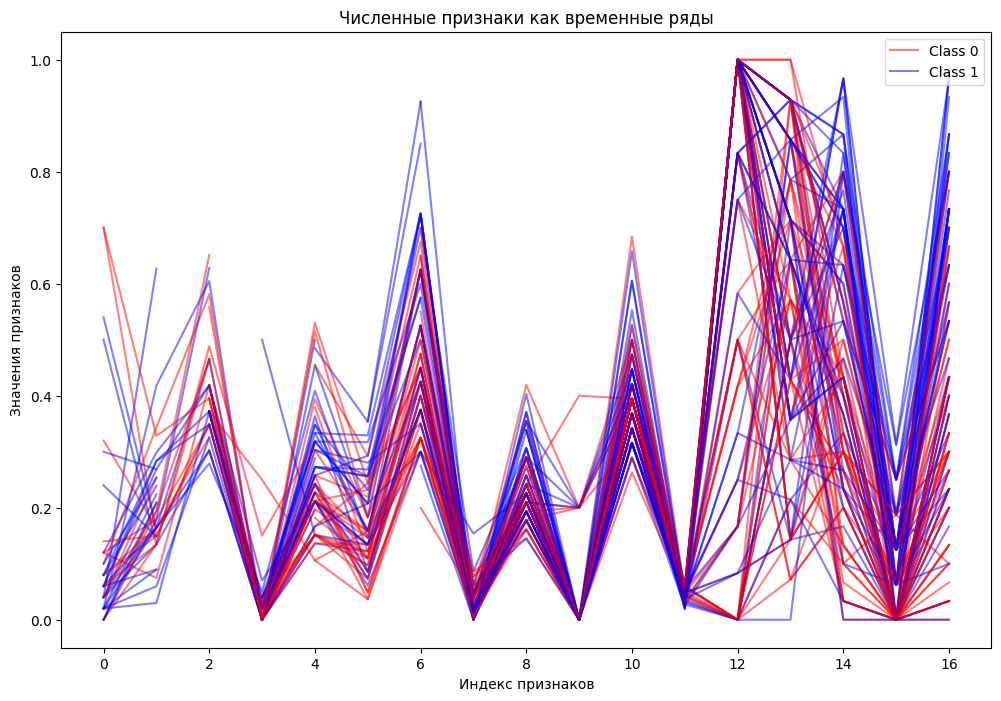

In [70]:
n_samples = 100
sample_n = data[features_n].sample(n_samples, random_state=42)
target = 'service_a'
target_samples = data.loc[sample_n.index, target]

colors = {0: 'blue', 1: 'red'}

plt.figure(figsize=(12, 8))
for i in range(n_samples):
    row_example = sample_n.iloc[i, :]
    target_class = target_samples.iloc[i]
    plt.plot(row_example.values, color=colors[target_class], alpha=0.5)

plt.title('Численные признаки как временные ряды')
plt.xlabel('Индекс признаков')
plt.ylabel('Значения признаков')
plt.legend([f'Class {key}' for key in colors.keys()], loc='upper right')
plt.show()


Графики явно не особо похожи на классические временные ряды :)

Можно сказать, что после 12 индекса видна более явно хаотичность, возможно следует обрезать признаки как раз по этому индексу.

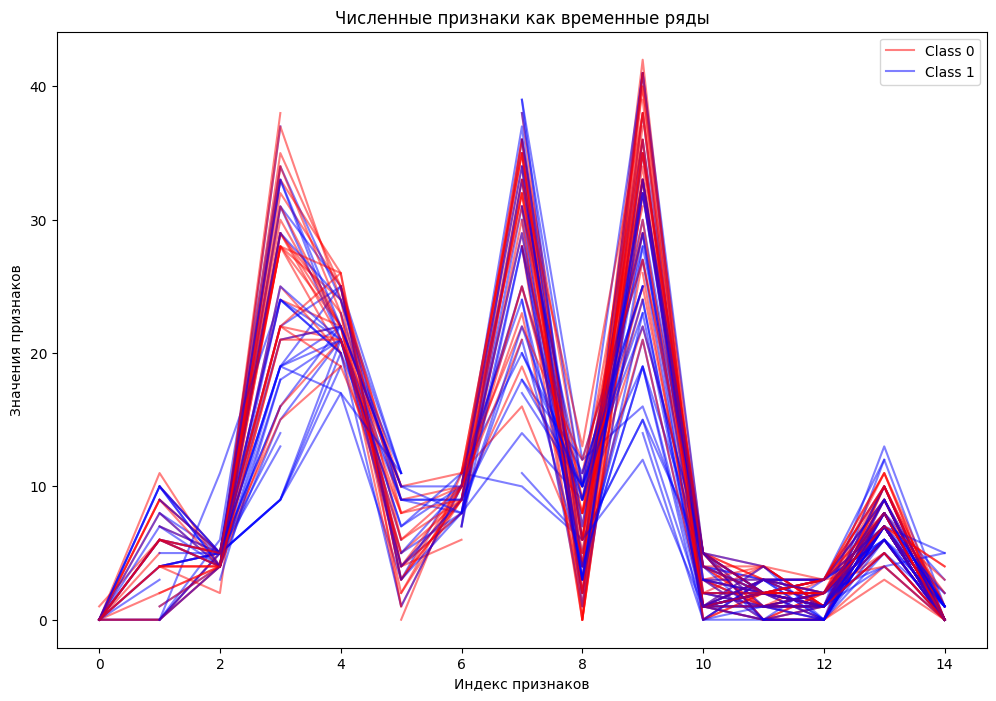

In [71]:
n_samples = 100
sample_n = data[features_o].sample(n_samples, random_state=42)
target = 'service_a'
target_samples = data.loc[sample_n.index, target]

colors = {0: 'blue', 1: 'red'}

plt.figure(figsize=(12, 8))
for i in range(n_samples):
    row_example = sample_n.iloc[i, :]
    target_class = target_samples.iloc[i]
    plt.plot(row_example.values, color=colors[target_class], alpha=0.5)

plt.title('Численные признаки как временные ряды')
plt.xlabel('Индекс признаков')
plt.ylabel('Значения признаков')
plt.legend([f'Class {key}' for key in colors.keys()], loc='upper right')
plt.show()

Признаки шаблона o_{} следует нормализировать (StandartScaler или MinMaxScaler) в случае использования как основной модели логистическую регрессию.

# Выводы

Модели:

1) Логистическая регрессия.

Попробуем сначала ее, так как выходы (вероятности принадлежности классу) лог. регрессии хорошо откалиброваны. 

Будем использовать логистическую регрессию для всех 14 таргетов, независимо обучая ее для каждого таргета. Потом усредняем метрику по всем моделям. Для заполенения пропусков будем использовать SimpleImputer, с соответствующими параметрами в зависимости от вида признака. В EDA был найден класс признаков, которые не отнормированы, следует применить StandartScaler к ним (так как лог. регрессия чувствительна к этому), а остальные не трогать, так как их значения находятся в диапазоне [0, 1].

2) Градиентный бустинг (CatBoostClassifier)

Попробуем более продвинутую модель, но выходы бустинга плохо откалиброваны. Придется применять калибровку: калибровка Плата, бетта калибровка. Плюс этой модели в том, что обрабатывать nan не надо, catboost хорошо сам с этим справляется. Нормализация числовых признаков не нужна, так как модель устойчива к подобной проблеме. Преобразование категориальных признаков тоже не нужна, catboost сам решает как лучше это сделать :)

3) Нейронки

Изначально я думал, что тут надо будет написать какую-то нейронку для решения, так как выходы нейронки хорошо интерпретируются как вероятности и тд, но из-за того, что данных для обучения у нас мало (всего 8000), а для обучения нейронок в основном требуются большие объемы данных. Поэтому эту идею оставлю..

На собеседовании мне сказали, что здесь могут быть какие то временные ряды, но посмотрев на данные внимательнее, каких то явных признаков временных рядов я не заметил (сезонности и тд). Плюс качество данных не очень хорошее, слишком много пропусков, преобладают именно категориальные признаки, а не числовые, поэтому строить конкретно модели, нацеленные на прогнозирование временных рядов (ARIMA, SARIMA, ARIMAX), и добавлять лаговые признаки, я посчитал не стоит.


В папке utils, в файле make_full_pipeline.py реализованы все трансформеры и пайплайны для обучения и инференса модели.